In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random
import torch
import os

SEED = 42

DATA_PATH = '/content/drive/MyDrive/데이터 분석/데이콘 캐글 컴페티션/예슬 개인 참가/대구 교통사고 피해 예측/data/'

In [ ]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False


seed_everything(SEED)

In [ ]:
# 전국 데이터로 돌려보기

country_acc = pd.read_csv(f'{DATA_PATH}countrywide_accident.csv') #

KR_cctv = pd.read_csv(f'{DATA_PATH}전국무인교통단속카메라표준데이터.csv', encoding='cp949')
DG_cctv = pd.read_csv(f'{DATA_PATH}대구 CCTV 정보.csv', encoding='cp949')

KR_seculight =pd.read_csv(f'{DATA_PATH}전국보안등정보표준데이터.csv', encoding='cp949')
DG_seculight = pd.read_csv(f'{DATA_PATH}대구 보안등 정보.csv', encoding='cp949')

KR_children_area = pd.read_csv(f'{DATA_PATH}전국어린이보호구역표준데이터.csv', encoding='cp949')
DG_children_area = pd.read_csv(f'{DATA_PATH}대구 어린이 보호 구역 정보.csv', encoding='cp949')

KR_parking = pd.read_csv(f'{DATA_PATH}전국주차장정보표준데이터.csv', encoding='cp949')
DG_parking = pd.read_csv(f'{DATA_PATH}대구 주차장 정보.csv', encoding='cp949')

train = pd.read_csv(f'{DATA_PATH}train.csv')
train_df = pd.read_csv(f'{DATA_PATH}train.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')

<ipython-input-4-5cee2bfefacc>:5: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  KR_cctv = pd.read_csv(f'{DATA_PATH}전국무인교통단속카메라표준데이터.csv', encoding='cp949')
<ipython-input-4-5cee2bfefacc>:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  DG_seculight = pd.read_csv(f'{DATA_PATH}대구 보안등 정보.csv', encoding='cp949')


In [ ]:
# country_acc = pd.read_csv(f'{DATA_PATH}countrywide_accident.csv') #

KR_train_df = pd.concat([country_acc, train_df], axis=0).reset_index().drop(columns = 'index')
KR_train_df.shape, country_acc.shape, train_df.shape

((642384, 23), (602775, 23), (39609, 23))

- 전국 보안등정보 df

In [ ]:
KR_seculight = KR_seculight.fillna(0)

KR_seculight = KR_seculight[KR_seculight['데이터기준일자'] <= '2021.12.31'].iloc[:,:8]

In [ ]:
mask = ((KR_seculight['소재지도로명주소'].str.startswith('대구')) |(KR_seculight['소재지지번주소'].str.startswith('대구')))
KR_seculight = KR_seculight[~mask]

In [ ]:
KR_seculight_df = pd.concat([KR_seculight, DG_seculight], axis=0).reset_index().drop(columns = 'index')

In [ ]:
KR_seculight_df.shape, KR_seculight.shape, DG_seculight.shape

((86467, 8), (14554, 8), (71913, 8))

- 전국 어린이보호구역 df

In [ ]:
KR_children_area = KR_children_area.fillna(0)

KR_children_area = KR_children_area[KR_children_area['데이터기준일자'] <= '2021.12.31'].iloc[:,:12]

In [ ]:
mask = ((KR_children_area['소재지도로명주소'].str.startswith('대구')) |(KR_children_area['소재지지번주소'].str.startswith('대구')))
KR_children_area = KR_children_area[~mask]

In [ ]:
KR_children_area_df = pd.concat([KR_children_area,DG_children_area], axis=0).reset_index().drop(columns = 'index')

KR_children_area_df.shape, KR_children_area.shape, DG_children_area.shape

((1146, 12), (506, 12), (640, 12))

- 전국 cctv df

In [ ]:
DG_cctv.columns

Index(['무인교통단속카메라관리번호', '시도명', '시군구명', '도로종류', '도로노선번호', '도로노선명', '도로노선방향',
       '소재지도로명주소', '소재지지번주소', '위도', '경도', '설치장소', '단속구분', '제한속도', '단속구간위치구분',
       '과속단속구간길이', '보호구역구분', '설치연도'],
      dtype='object')

In [ ]:
KR_cctv = KR_cctv.fillna(0)
KR_cctv = KR_cctv[KR_cctv['데이터기준일자'] <= '2021.12.31']

In [ ]:
mask = ((KR_cctv['소재지도로명주소'].str.startswith('대구')) |(KR_cctv['소재지지번주소'].str.startswith('대구')))
KR_cctv = KR_cctv[~mask]

In [ ]:
drop_cols = ['관리기관명', '관리기관전화번호', '데이터기준일자', '제공기관코드','제공기관명']
KR_cctv = KR_cctv.drop(columns = drop_cols)

In [ ]:
KR_cctv_df = pd.concat([KR_cctv,DG_cctv], axis=0).reset_index().drop(columns = 'index')

KR_cctv_df.shape, KR_cctv.shape, DG_cctv.shape

((1409, 18), (344, 18), (1065, 18))

- 전국 주차장 정보 df

In [ ]:
drop_cols = ['관리기관명', '전화번호','장애인전용주차구역보유여부','제공기관코드', '제공기관명']
KR_parking = KR_parking.drop(columns = drop_cols)

KR_parking = KR_parking.fillna(0)
KR_parking = KR_parking[KR_parking['데이터기준일자'] <= '2021.12.31']

In [ ]:
mask = ((KR_parking['소재지도로명주소'].str.startswith('대구')) |(KR_parking['소재지지번주소'].str.startswith('대구')))
KR_parking = KR_parking[~mask]

In [ ]:
KR_parking_df = pd.concat([KR_parking,DG_parking], axis=0).reset_index().drop(columns = 'index')

KR_parking_df.shape, KR_parking.shape, DG_parking.shape

# KR_parking_df = KR_parking_df['급지구분']

KR_parking_df.columns

Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '소재지지번주소', '주차구획수',
       '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항',
       '위도', '경도', '데이터기준일자'],
      dtype='object')

In [ ]:
KR_parking_df['급지구분'] = KR_parking_df['급지구분'].astype(str)


- 지역별 보안등 수

In [ ]:
KR_seculight_df

location_pattern =  r'(\S+) (\S+) (\S+) (\S+)'

KR_seculight_df[['도시','구','동','번지']] = KR_seculight_df['소재지지번주소'].str.extract(location_pattern)
KR_seculight_df = KR_seculight_df.drop(columns=['소재지지번주소', '번지'])

KR_seculight_df = KR_seculight_df.groupby(['도시', '구', '동']).sum().reset_index()
KR_seculight_df.reset_index(inplace=True, drop=True)

KR_seculight_df.rename(columns = {'설치개수': '보안등_설치개수'}, inplace=True)
KR_seculight_df = KR_seculight_df[['도시','구','동','보안등_설치개수']]

<ipython-input-22-ab15bf06834a>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  KR_seculight_df = KR_seculight_df.groupby(['도시', '구', '동']).sum().reset_index()


- 지역별 보호구역 수

In [ ]:
KR_children_area_df

location_pattern =  r'(\S+) (\S+) (\S+) (\S+)'

KR_children_area_df[['도시','구','동','번지']] = KR_children_area_df['소재지지번주소'].str.extract(location_pattern)
KR_children_area_df = KR_children_area_df.drop(columns=['소재지지번주소', '번지'])

KR_children_area_df = KR_children_area_df.groupby(['도시', '구', '동']).sum().reset_index()
KR_children_area_df.reset_index(inplace=True, drop=True)

KR_children_area_df.rename(columns = {'CCTV설치대수' : '보호구역_cctv대수'}, inplace=True)
KR_children_area_df = KR_children_area_df[['도시','구','동','보호구역_cctv대수']]

<ipython-input-23-7b7e5f39a2ff>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  KR_children_area_df = KR_children_area_df.groupby(['도시', '구', '동']).sum().reset_index()


- 지역별 급지 및 주차구역 수

In [ ]:
KR_parking_df.columns

Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '소재지지번주소', '주차구획수',
       '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항',
       '위도', '경도', '데이터기준일자'],
      dtype='object')

In [ ]:
KR_parking_df = pd.get_dummies(KR_parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

KR_parking_df[['도시', '구', '동', '번지']] = KR_parking_df['소재지지번주소'].str.extract(location_pattern)
KR_parking_df = KR_parking_df.drop(columns=['소재지지번주소', '번지'])

KR_parking_df = KR_parking_df.groupby(['도시', '구', '동']).sum().reset_index()
KR_parking_df.reset_index(inplace=True, drop=True)

KR_parking_df = KR_parking_df.drop(columns = ['주차구획수', '주차기본시간', '주차기본요금', '추가단위시간','1일주차권요금적용시간', '1일주차권요금', '위도', '경도'])

<ipython-input-25-e0f246fcf52a>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  KR_parking_df = KR_parking_df.groupby(['도시', '구', '동']).sum().reset_index()


- 지역별 cctv 수

In [ ]:
# KR_cctv_df['CCTV설치대수_2'] =1

In [ ]:
# KR_cctv_df

# location_pattern =  r'(\S+) (\S+) (\S+) (\S+)'

# KR_cctv_df[['도시','구','동','번지']] = KR_cctv_df['소재지지번주소'].str.extract(location_pattern)
# KR_cctv_df = KR_cctv_df.drop(columns=['소재지지번주소', '번지'])

# KR_cctv_df = KR_cctv_df.groupby(['도시', '구', '동']).sum().reset_index()
# KR_cctv_df.reset_index(inplace=True, drop=True)

# KR_cctv_df

In [ ]:
# KR_train_df
#연, 월, 일, 시간, 사고일시

train_df = KR_train_df.copy()
test_df = test_df.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = KR_train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = KR_train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = KR_train_df['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [ ]:
train_df = pd.merge(train_df, KR_seculight_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, KR_children_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, KR_parking_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, KR_seculight_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, KR_children_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, KR_parking_df, how='left', on=['도시', '구', '동'])

In [ ]:
train_df

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,도로형태1,도로형태2,보안등_설치개수,보호구역_cctv대수,급지구분_1,급지구분_2,급지구분_3,급지구분_4,급지구분_5,급지구분_기타
0,COUNTRYWIDE_ACCIDENT_000000,화요일,맑음,건조,차대사람,횡단중,보행자보호의무위반,승용,남,26세,...,교차로,교차로횡단보도내,NaN,NaN,3.0,0.0,0.0,1.0,0.0,0.0
1,COUNTRYWIDE_ACCIDENT_000001,화요일,맑음,건조,차대차,기타,직진우회전진행방해,승용,남,54세,...,교차로,교차로안,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,COUNTRYWIDE_ACCIDENT_000002,화요일,맑음,건조,차대차,측면충돌,신호위반,승용,여,57세,...,교차로,교차로안,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,COUNTRYWIDE_ACCIDENT_000003,화요일,맑음,건조,차대사람,횡단중,보행자보호의무위반,승용,여,65세,...,기타,기타,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COUNTRYWIDE_ACCIDENT_000004,화요일,맑음,건조,차대차,측면충돌,신호위반,승용,여,74세,...,교차로,교차로안,NaN,NaN,2.0,9.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642379,ACCIDENT_39604,금요일,맑음,건조,차대차,측면충돌,신호위반,승용,여,52세,...,교차로,교차로안,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
642380,ACCIDENT_39605,금요일,맑음,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,...,단일로,기타,843.0,NaN,0.0,0.0,5.0,0.0,0.0,0.0
642381,ACCIDENT_39606,금요일,맑음,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,...,교차로,교차로안,164.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0
642382,ACCIDENT_39607,금요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,40세,...,기타,기타,210.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642384 entries, 0 to 642383
Data columns (total 37 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           642384 non-null  object 
 1   요일           642384 non-null  object 
 2   기상상태         642384 non-null  object 
 3   노면상태         642383 non-null  object 
 4   사고유형         642384 non-null  object 
 5   사고유형 - 세부분류  642384 non-null  object 
 6   법규위반         642384 non-null  object 
 7   가해운전자 차종     642384 non-null  object 
 8   가해운전자 성별     642384 non-null  object 
 9   가해운전자 연령     642384 non-null  object 
 10  가해운전자 상해정도   642384 non-null  object 
 11  피해운전자 차종     615566 non-null  object 
 12  피해운전자 성별     615564 non-null  object 
 13  피해운전자 연령     615567 non-null  object 
 14  피해운전자 상해정도   615564 non-null  object 
 15  사망자수         642384 non-null  int64  
 16  중상자수         642384 non-null  int64  
 17  경상자수         642384 non-null  int64  
 18  부상자수         642384 non-

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10963 entries, 0 to 10962
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           10963 non-null  object 
 1   요일           10963 non-null  object 
 2   기상상태         10963 non-null  object 
 3   노면상태         10963 non-null  object 
 4   사고유형         10963 non-null  object 
 5   연            10963 non-null  int64  
 6   월            10963 non-null  int64  
 7   일            10963 non-null  int64  
 8   시간           10963 non-null  int64  
 9   도시           10963 non-null  object 
 10  구            10963 non-null  object 
 11  동            10963 non-null  object 
 12  도로형태1        10963 non-null  object 
 13  도로형태2        10963 non-null  object 
 14  보안등_설치개수     8192 non-null   float64
 15  보호구역_cctv대수  6002 non-null   float64
 16  급지구분_1       9035 non-null   float64
 17  급지구분_2       9035 non-null   float64
 18  급지구분_3       9035 non-null   float64
 19  급지구분

In [ ]:
test_x = test_df.drop(columns=['ID']).copy()
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()

test_x.shape, train_x.shape, train_y.shape

((10963, 21), (642384, 21), (642384,))

In [ ]:
test_df

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,...,도로형태1,도로형태2,보안등_설치개수,보호구역_cctv대수,급지구분_1,급지구분_2,급지구분_3,급지구분_4,급지구분_5,급지구분_기타
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,...,교차로,교차로안,700.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,...,단일로,기타,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,...,교차로,교차로안,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,...,단일로,기타,NaN,0.0,0.0,2.0,1.0,0.0,0.0,0.0
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,...,교차로,교차로안,932.0,NaN,0.0,1.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,...,단일로,터널,5377.0,106.0,20.0,1.0,0.0,0.0,0.0,0.0
10959,ACCIDENT_50568,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,...,단일로,기타,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
10960,ACCIDENT_50569,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,...,단일로,기타,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10961,ACCIDENT_50570,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,...,교차로,교차로부근,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
display(test_x.columns)
display(train_x.columns)

Index(['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',
       '도로형태1', '도로형태2', '보안등_설치개수', '보호구역_cctv대수', '급지구분_1', '급지구분_2',
       '급지구분_3', '급지구분_4', '급지구분_5', '급지구분_기타'],
      dtype='object')

Index(['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',
       '도로형태1', '도로형태2', '보안등_설치개수', '보호구역_cctv대수', '급지구분_1', '급지구분_2',
       '급지구분_3', '급지구분_4', '급지구분_5', '급지구분_기타'],
      dtype='object')

In [ ]:
train_x

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,...,도로형태1,도로형태2,보안등_설치개수,보호구역_cctv대수,급지구분_1,급지구분_2,급지구분_3,급지구분_4,급지구분_5,급지구분_기타
0,화요일,맑음,건조,차대사람,2019,1,1,0,서울특별시,강서구,...,교차로,교차로횡단보도내,NaN,NaN,3.0,0.0,0.0,1.0,0.0,0.0
1,화요일,맑음,건조,차대차,2019,1,1,0,경기도,포천시,...,교차로,교차로안,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,화요일,맑음,건조,차대차,2019,1,1,0,경기도,양주시,...,교차로,교차로안,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,화요일,맑음,건조,차대사람,2019,1,1,0,경기도,남양주시,...,기타,기타,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,화요일,맑음,건조,차대차,2019,1,1,0,인천광역시,부평구,...,교차로,교차로안,NaN,NaN,2.0,9.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642379,금요일,맑음,건조,차대차,2021,12,31,19,대구광역시,수성구,...,교차로,교차로안,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
642380,금요일,맑음,건조,차대차,2021,12,31,19,대구광역시,달서구,...,단일로,기타,843.0,NaN,0.0,0.0,5.0,0.0,0.0,0.0
642381,금요일,맑음,건조,차대차,2021,12,31,21,대구광역시,달서구,...,교차로,교차로안,164.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0
642382,금요일,맑음,건조,차대차,2021,12,31,22,대구광역시,달서구,...,기타,기타,210.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)


['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

In [ ]:

for i in categorical_features:
    le = LabelEncoder()
    train_x[i] = le.fit_transform(train_x[i])
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,...,도로형태1,도로형태2,보안등_설치개수,보호구역_cctv대수,급지구분_1,급지구분_2,급지구분_3,급지구분_4,급지구분_5,급지구분_기타
0,6,2,0,0,2019,1,1,0,9,5,...,0,4,NaN,NaN,3.0,0.0,0.0,1.0,0.0,0.0
1,6,2,0,1,2019,1,1,0,1,194,...,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,2,0,1,2019,1,1,0,1,117,...,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,2,0,0,2019,1,1,0,1,47,...,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,2,0,1,2019,1,1,0,12,81,...,0,3,NaN,NaN,2.0,9.0,1.0,0.0,0.0,0.0


,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,...,도로형태1,도로형태2,보안등_설치개수,보호구역_cctv대수,급지구분_1,급지구분_2,급지구분_3,급지구분_4,급지구분_5,급지구분_기타
0,5,2,0,0,2022,1,1,1,5,102,...,0,3,700.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,5,2,0,0,2022,1,1,1,5,102,...,2,5,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,5,2,0,1,2022,1,1,4,5,102,...,0,3,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,5,2,0,1,2022,1,1,4,5,102,...,2,5,NaN,0.0,0.0,2.0,1.0,0.0,0.0,0.0
4,5,2,0,1,2022,1,1,6,5,53,...,0,3,932.0,NaN,0.0,1.0,3.0,0.0,0.0,0.0


In [ ]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [ ]:
train_x

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,...,도로형태1,도로형태2,보안등_설치개수,보호구역_cctv대수,급지구분_1,급지구분_2,급지구분_3,급지구분_4,급지구분_5,급지구분_기타
0,6,2,0,0,2019,1,1,0,9,5,...,0,4,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0
1,6,2,0,1,2019,1,1,0,1,194,...,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,2,0,1,2019,1,1,0,1,117,...,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,2,0,0,2019,1,1,0,1,47,...,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,2,0,1,2019,1,1,0,12,81,...,0,3,0.0,0.0,2.0,9.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642379,0,2,0,1,2021,12,31,19,5,102,...,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
642380,0,2,0,1,2021,12,31,19,5,53,...,2,5,843.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
642381,0,2,0,1,2021,12,31,21,5,53,...,0,3,164.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
642382,0,2,0,1,2021,12,31,22,5,53,...,1,5,210.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
test_x

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,...,도로형태1,도로형태2,보안등_설치개수,보호구역_cctv대수,급지구분_1,급지구분_2,급지구분_3,급지구분_4,급지구분_5,급지구분_기타
0,5,2,0,0,2022,1,1,1,5,102,...,0,3,700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,2,0,0,2022,1,1,1,5,102,...,2,5,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,5,2,0,1,2022,1,1,4,5,102,...,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,2,0,1,2022,1,1,4,5,102,...,2,5,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
4,5,2,0,1,2022,1,1,6,5,53,...,0,3,932.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,5,2,0,1,2022,12,31,18,5,45,...,2,10,5377.0,106.0,20.0,1.0,0.0,0.0,0.0,0.0
10959,5,2,0,1,2022,12,31,18,5,102,...,2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10960,5,2,0,1,2022,12,31,20,5,102,...,2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10961,5,2,0,1,2022,12,31,20,5,102,...,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
print(train_x.shape, train_y.shape)
print(train_x.isnull().sum().sum(), train_y.isnull().sum().sum())

(642384, 21) (642384,)
0 0


In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

# model = create_model()
# history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
#                     epochs=100,
#                     callbacks=callbacks_list,
#                     validation_split=0.1)

In [ ]:
print(train_x.shape, train_y.shape)
print(train_x.isnull().sum().sum(), train_y.isnull().sum().sum())

# model = create_model()
# history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
#                     epochs=100,
#                     validation_split=0.1)

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

(642384, 21) (642384,)
0 0
Epoch 1/100
18068/18068 [==============================] - 78s 4ms/step - loss: 0.4457 - metric_fn: 0.4457 - val_loss: 0.4487 - val_metric_fn: 0.4487 - lr: 0.0010
Epoch 2/100
18068/18068 [==============================] - 75s 4ms/step - loss: 0.4409 - metric_fn: 0.4409 - val_loss: 0.4385 - val_metric_fn: 0.4385 - lr: 0.0010
Epoch 3/100
18068/18068 [==============================] - 73s 4ms/step - loss: 0.4405 - metric_fn: 0.4405 - val_loss: 0.4350 - val_metric_fn: 0.4350 - lr: 0.0010
Epoch 4/100
18068/18068 [==============================] - 71s 4ms/step - loss: 0.4401 - metric_fn: 0.4401 - val_loss: 0.4333 - val_metric_fn: 0.4334 - lr: 0.0010
Epoch 5/100
18068/18068 [==============================] - 73s 4ms/step - loss: 0.4398 - metric_fn: 0.4398 - val_loss: 0.4346 - val_metric_fn: 0.4346 - lr: 0.0010
Epoch 6/100
18068/18068 [==============================] - 71s 4ms/step - loss: 0.4397 - metric_fn: 0.4397 - val_loss: 0.4351 - val_metric_fn: 0.4351 - lr: 0.

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define a callback to save the model after each epoch
# checkpoint_callback = ModelCheckpoint('path_to_save_model', save_freq='epoch')

# # Train the model with the callback
# history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
#                     epochs=100,
#                     validation_split=0.1,
#                     callbacks=[checkpoint_callback])


In [ ]:
# checkpoint_callback = ModelCheckpoint('models/model_{epoch:02d}_{val_loss:.4f}.h5', save_freq='epoch')


In [ ]:
model.save(f'{DATA_PATH}tf_dense_model_1121')

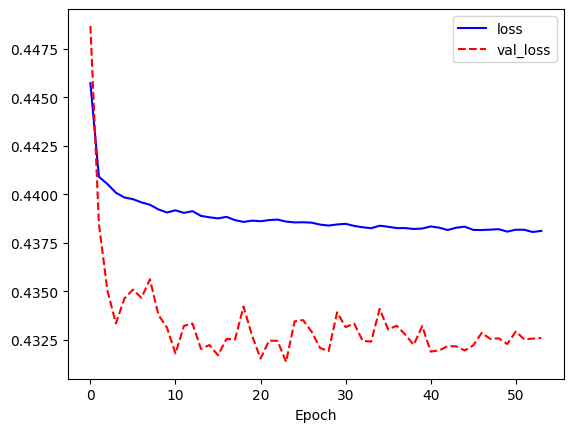

In [ ]:
# train loss, val loss 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:

submission["ECLO"] = model.predict(test_x.astype('float32'))
submission


343/343 [==============================] - 1s 2ms/step


,ID,ECLO
0,ACCIDENT_39609,4.093636
1,ACCIDENT_39610,3.779192
2,ACCIDENT_39611,4.747542
3,ACCIDENT_39612,4.384857
4,ACCIDENT_39613,4.200002
...,...,...
10958,ACCIDENT_50567,4.623382
10959,ACCIDENT_50568,4.402130
10960,ACCIDENT_50569,4.410460
10961,ACCIDENT_50570,4.425819


In [ ]:
submission.to_csv("submission_dense_v1_1122.csv", index=False)